## Load modules

In [3]:
import numpy as np
import yaml
import glob
import matplotlib.pyplot as plt

## Load data, select sensors, and low-pass filtering

Run the following to first prepare the data (of the first trial), which will be used later to demonstrate how to get frequency-domain features (spectrogram). The MEG_dim_selection and low_pass_filtering are taken from debug.ipynb.

In [4]:
data_path = '/home/beiming/RAW_DATA/MEG/case0554_A2_220715/Sentences/Baseline'
#data_path = '../Sentences/Articulation' # Change data path if needed
phone_list_path = 'PB400_phone.txt'
config = yaml.load(open('conf/conf.yaml', 'r'), Loader=yaml.FullLoader)

In [5]:
meg_list = glob.glob(data_path + '/*.txt')
meg_list.sort()

sample_meg = np.loadtxt(meg_list[0])

dim_range = config['MEG_data']['selected_dims']

In [6]:
class MEG_dim_selection(object):
    def __init__(self, dim_range):
        self.dim_range = dim_range
    def __call__(self, X):
        if len(dim_range) % 2 != 0:
            raise Exception("Nums of starts and ends don't match, please check!")
        sel = []   
        for i in range(len(dim_range)//2):
            start = dim_range[2*i]
            end = dim_range[2*i+1]            
            _X = X[:,start:end]           
            sel.append(_X)   
        X_sel = np.hstack(sel)
        return X_sel
    
dim_sel = MEG_dim_selection(dim_range)
X_sel = dim_sel(sample_meg)

print(X_sel.shape)

(3835, 50)


In [7]:
class low_pass_filtering(object):
    def __init__(self, cutoff_freq, fs):
        
        self.fs = fs
        self.cutoff_freq = cutoff_freq
    def __call__(self, I):
        if self.cutoff_freq >= self.fs//2:
            raise Exception("Cutoff freq must be lower than half of the sampling rate, based on the Nyquist criterion")
        from scipy.signal import butter, lfilter
        cutoff_norm = self.cutoff_freq/(self.fs/2)
        b, a = butter(5, cutoff_norm, btype='low', analog=False)
        I_filtered_list = []
        for i in range(I.shape[1]):
            _I = lfilter(b, a, I[:,i])
            I_filtered_list.append(_I)
            I_filtered = np.vstack(I_filtered_list)

        return I_filtered.T
    
LP = low_pass_filtering(100, 1000)
S_F = LP(sample_meg)
print(S_F.shape)

(3835, 204)


## MEG_freq_feats

I assume that we'll extract frequency-domain features in the `1_data_prepare.py` step so I created a class called `MEG_freq_feats`. I think I can be added to `transforms` in `1_data_prepare.py` and then we can use `Transform_Compose` to transform the original MEG timeseries into spectrograms. Please feel free to modify the code if anything doesn't work. Thanks!

In [16]:
class MEG_freq_feats(object):
    """
    Input: 2-D MEG data array (shape: (samples, channels/sensors))
    ---
    For more details about the first 5 argunebts, please see the signal.spectrogram() function of the scipy package:
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html
    
    fs:
        Sampling frequency in Hz (default: 1000)
    window:
        Window to use (default: ('tukey', 0.25))
    nperseg:
        Length of each segment (default: 128)
    noveral:
        Overlap between segments (default: None)
    nfft:
        Length of the FFT (default: None)
    log_transform:
        Apply log-transformation to the spectrogram? (default: True)
    freq_range:
        Frequency range to retain in the spectrogram (default: (0, 130), from 0 Hz to 130 Hz) 
    ---
    Output: 3-D array containing spectrograms of all channels (shape: (channels/sensors, frequency, time))
    """
    def __init__(self, fs = 1000, window = ('tukey', 0.25), 
                 nperseg = 128, noverlap = None, nfft = None,
                log_transform = True,
                freq_range = (0, 130)):
        self.fs = fs
        self.window = window
        self.nperseg = nperseg
        self.noverlap = noverlap
        self.nfft = nfft
        self.log_transform = log_transform
        self.freq_min, self.freq_max = freq_range
        
    def __call__(self, I):
        from scipy import signal
        
        all_specs = []
        
        # Loop through all channels/sensors
        for i in range(I.shape[1]):
            
            # Get the MEG timeseries of the current channel and its spectrogram
            X = I[:, i]
            f, t, spec = signal.spectrogram(X, fs = self.fs, window = self.window,
                                            nperseg = self.nperseg, noverlap = self.noverlap,
                                            nfft = self.nfft)
            print(spec.shape)
            # Apply log transformation if needed
            if self.log_transform: 
                spec = np.log(spec)
            
            if all_specs:
                spec = spec[idx_band, :]
                all_specs.append(spec)
            else:
                # Keep just the part of the spectrogram within the required frequency band
                # (idx_band needs to be computed only at the first iteration since it should be the 
                # same across all channels/sensors)
                idx_band = np.logical_and(f >= self.freq_min, f <= self.freq_max)
                spec = spec[idx_band, :]
                all_specs.append(spec)
        
        all_specs = np.array(all_specs)
        return f[idx_band], t, all_specs

# A helper function to help visualize the spectrogram
def plot_specs(f, t, all_specs, channels = 0):
    if isinstance(channels, list):
        n_rows = (len(channels) // 5) + int((len(channels) % 5) > 0)
        fig, axs = plt.subplots(n_rows, 5, figsize = (22, 6 * n_rows))
        for chan_list_idx in range(len(channels)):
            spec = all_specs[channels[chan_list_idx], :, :]
            row_idx = chan_list_idx // 5
            col_idx = chan_list_idx % 5
            img = axs[row_idx, col_idx].pcolormesh(t, f, spec)
            if col_idx == 0:
                axs[row_idx, col_idx].set_ylabel(f'Frequency [Hz]')
            axs[row_idx, col_idx].set_xlabel(f'Time [sec]')
            axs[row_idx, col_idx].set_title(f'Channel {channels[chan_list_idx]}')
            plt.colorbar(img, ax = axs[row_idx, col_idx])
        plt.show()
    else:
        spec = all_specs[channels, :, :]
        plt.pcolormesh(t, f, spec)
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.title(f'Channel {channels}')
        plt.colorbar() 
        plt.show()

Applying the `MEG_freq_feats` class to the low-pass filtered signal `S_F`:

In [17]:
# Get MEG spectrograms
# S_F: filtered signals (shape: (3835, 204))
fdf = MEG_freq_feats(nperseg = 64, nfft = None, freq_range = (0, 500))
f, t, MEG_specs = fdf(S_F)

(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(33, 68)
(

In [18]:
print("Shape of spectrogram features (channels/sensors x frequency x time):")
print(MEG_specs.shape)

Shape of spectrogram features (channels/sensors x frequency x time):
(204, 33, 68)


We may want to modify the conf.yaml file as well so that we can specify the values of the various arguments of `MEG_freq_feats` in the yaml file and pass them to the `MEG_freq_feats` class.

Below we plots the spectrograms of some channels to see what they are like:

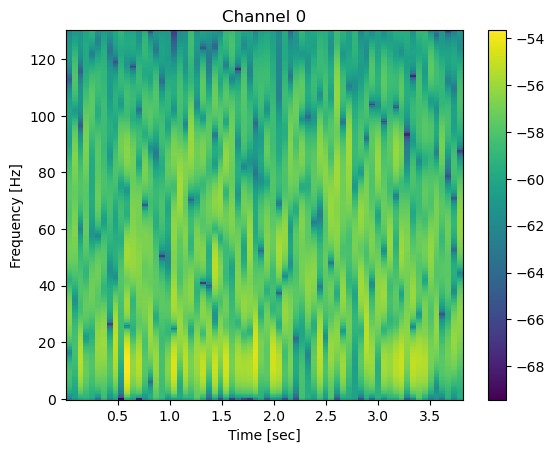

In [9]:
# Plot spectrogram of the first channel
plot_specs(f, t, MEG_specs, channels = 0)

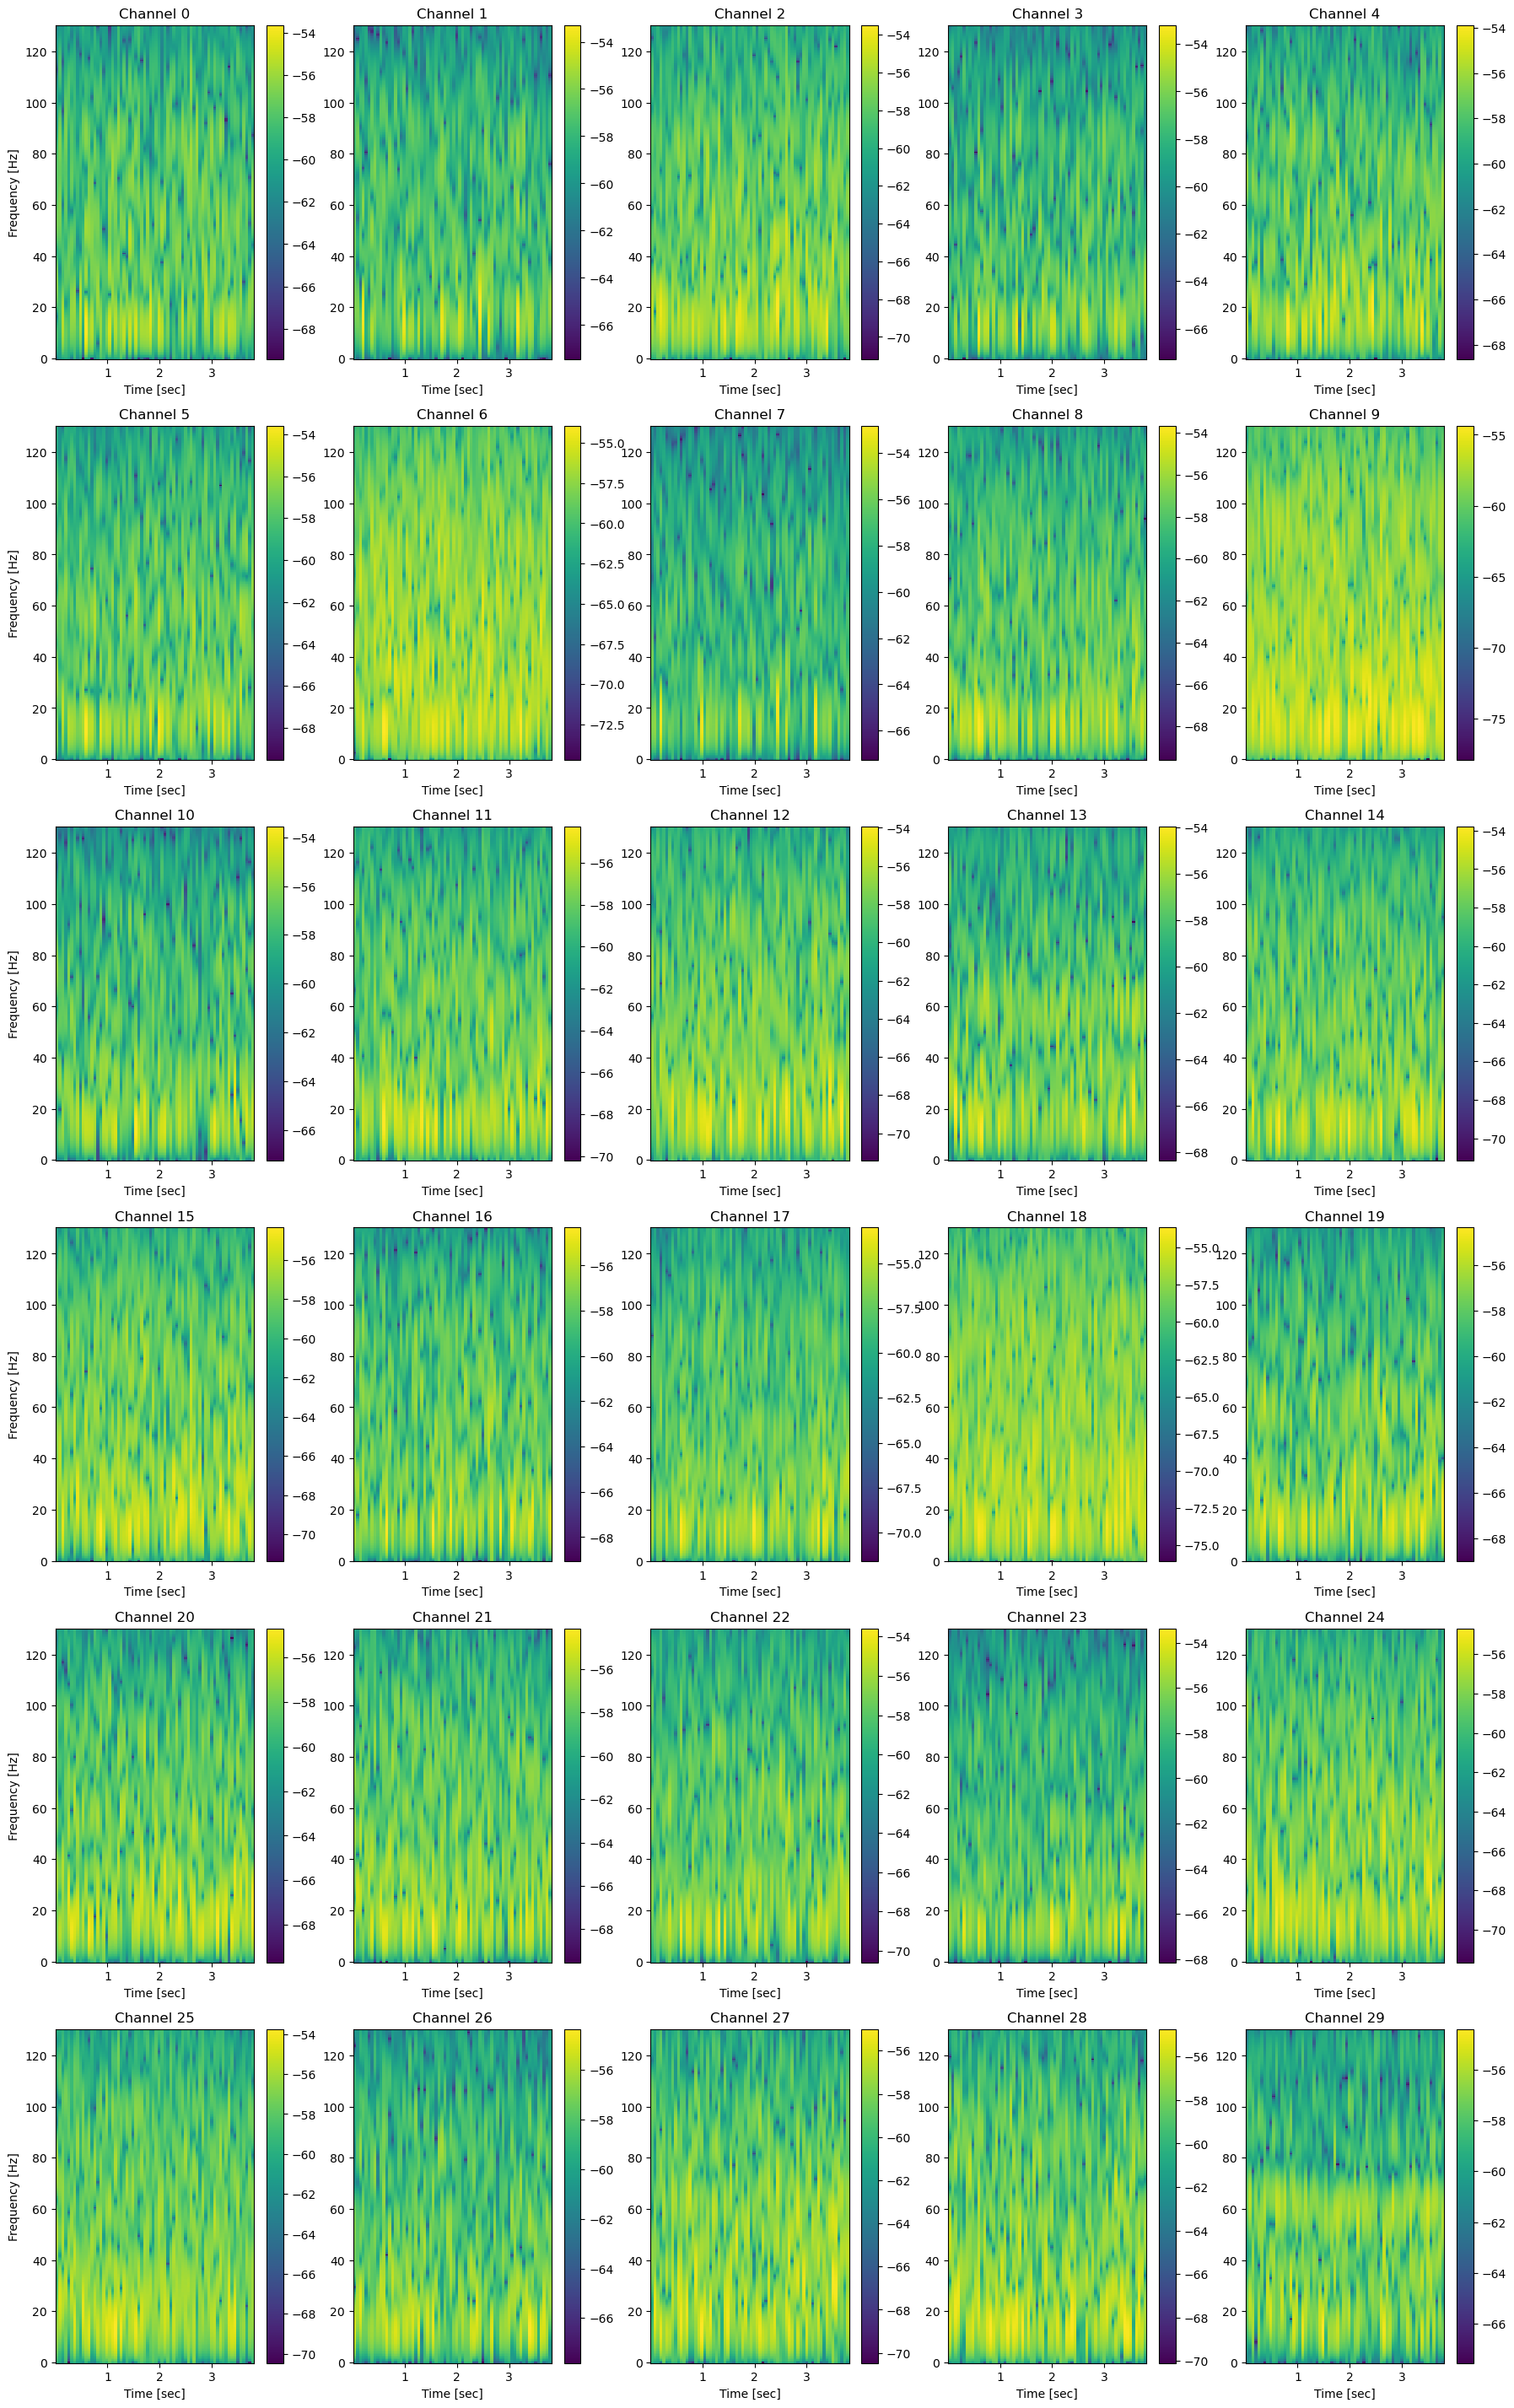

In [10]:
# Plot spectrograms of the first 30 channels
plot_specs(f, t, MEG_specs, channels = list(range(30)))